C:\Users\yvesv\AppData\Local\Temp\ipykernel_17332\3800527774.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


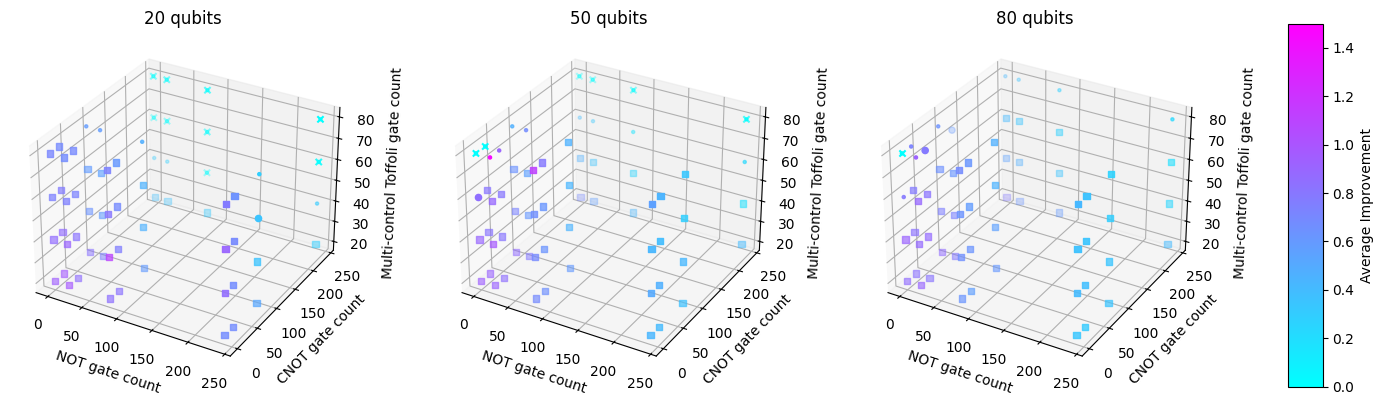

In [6]:
import random
import glob
import re
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np

qcircs = []
for qbit in [20, 50, 80]:
    for not_cnt in [0, 20, 80, 240]:
        for cnot_cnt in [0, 20, 80, 240]:
            for tof_cnt in [20, 40, 60, 80]:
                qcircs.append("{}_{}_{}_{}".format(qbit, not_cnt, cnot_cnt, tof_cnt))

data_qbit0_improv = []
data_qbit1_improv = []
data_qbit2_improv = []

data_qbit0_occur = []
data_qbit1_occur = []
data_qbit2_occur = []

min_avg_improv = 1
max_avg_improv = 0

for qcirc in qcircs:
    same_circ_files = glob.glob(f'benchmark_output/{qcirc}*')

    # print(same_circ_files)

    average_improvement_terms = 0
    num_valid_terms = 0
    occurrence_of_improv = 0

    qbit_used = 0
    not_cnt_used = 0
    cnot_cnt_used = 0
    tof_cnt_used = 0

    for file in same_circ_files: # in here, all qcircs are of same type, but different random seed        
        with open(file) as f:
            lines = [line.rstrip() for line in f]

        qcirc_info = lines[0].split("_")
        qbit = int(qcirc_info[0])
        not_cnt = int(qcirc_info[1])
        cnot_cnt = int(qcirc_info[2])
        tof_cnt = int(qcirc_info[3])
        my_seed = int(qcirc_info[4])

        qbit_used = qbit
        not_cnt_used = not_cnt
        cnot_cnt_used = cnot_cnt
        tof_cnt_used = tof_cnt

        quizx_term_cnt = lines[1].split(": ")[1]
        # DNF case
        if quizx_term_cnt == "NONE":
            quizx_term_cnt = -1
        quizx_term_cnt = int(quizx_term_cnt)
        
        quizx_runtime = lines[2].split(": ")[1]
        # DNF case
        if quizx_runtime == "STOPPED":
            quizx_runtime = -1
        quizx_runtime = float(quizx_runtime)

        if lines[3] == "": # cuz of small bug
            lines.pop(3)
        
        our_term_cnt = lines[3].split(": ")[1]
        # DNF case
        if our_term_cnt == "NONE":
            our_term_cnt = -1
        our_term_cnt = int(our_term_cnt)
        
        our_runtime = lines[4].split(": ")[1]
        # DNF case
        if our_runtime == "STOPPED":
            our_runtime = -1
        our_runtime = float(our_runtime)

        # print("{} {} {} {} {}".format(qbit, not_cnt, cnot_cnt, tof_cnt, my_seed))
        # print("{} {} {} {}".format(quizx_term_cnt, quizx_runtime, our_term_cnt, our_runtime))

        if quizx_term_cnt != -1 and our_term_cnt != -1:
            num_valid_terms += 1
            average_improvement_terms += quizx_term_cnt / our_term_cnt

            if quizx_term_cnt / our_term_cnt > 1:
                occurrence_of_improv += 1

        # print("-------")
    
    relevance = num_valid_terms / len(same_circ_files)

    if num_valid_terms != 0:
        average_improvement_terms /= num_valid_terms
        # print(average_improvement_terms)
        
        occurrence_of_improv = occurrence_of_improv / num_valid_terms

    if average_improvement_terms < min_avg_improv:
        min_avg_improv = average_improvement_terms
    if average_improvement_terms > max_avg_improv:
        max_avg_improv = average_improvement_terms

    if qbit_used == 20:
        data_qbit0_improv.append((not_cnt_used, cnot_cnt_used, tof_cnt_used, average_improvement_terms, relevance))
        data_qbit0_occur.append((not_cnt_used, cnot_cnt_used, tof_cnt_used, occurrence_of_improv, relevance))
    elif qbit_used == 50:
        data_qbit1_improv.append((not_cnt_used, cnot_cnt_used, tof_cnt_used, average_improvement_terms, relevance))
        data_qbit1_occur.append((not_cnt_used, cnot_cnt_used, tof_cnt_used, occurrence_of_improv, relevance))
    elif qbit_used == 80:
        data_qbit2_improv.append((not_cnt_used, cnot_cnt_used, tof_cnt_used, average_improvement_terms, relevance))
        data_qbit2_occur.append((not_cnt_used, cnot_cnt_used, tof_cnt_used, occurrence_of_improv, relevance))

# round up to first decimal place
min_avg_improv = np.ceil(min_avg_improv * 10) / 10.0
max_avg_improv = np.ceil(max_avg_improv * 10) / 10.0
norm = Normalize(vmin=min_avg_improv, vmax=max_avg_improv)
cmap = 'cool' #'seismic' #'rainbow' #'cool' # <-- good picks | Initial picks: viridis, RdYlGn, plasma


fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.1], wspace=0.3)

not_cnt0, cnot_cnt0, tof_cnt_used0, average_improvement_terms0, relevance0 = np.array(list(zip(*data_qbit0_improv)))

no_relevance_indices0 = (relevance0 == 0)
low_relevance_indices0 = (relevance0 < 1/3)
mid_relevance_indices0 = (1/3 <= relevance0) & (relevance0 < 2/3)
high_relevance_indices0 = (relevance0 >= 2/3)

ax1 = fig.add_subplot(gs[0], projection='3d')
scatter1_1 = ax1.scatter(not_cnt0[no_relevance_indices0], cnot_cnt0[no_relevance_indices0], tof_cnt_used0[no_relevance_indices0],
                         c=average_improvement_terms0[no_relevance_indices0], norm=norm, cmap=cmap, marker='x')
scatter1_2 = ax1.scatter(not_cnt0[low_relevance_indices0], cnot_cnt0[low_relevance_indices0], tof_cnt_used0[low_relevance_indices0],
                         c=average_improvement_terms0[low_relevance_indices0], norm=norm, cmap=cmap, marker='.')
scatter1_3 = ax1.scatter(not_cnt0[mid_relevance_indices0], cnot_cnt0[mid_relevance_indices0], tof_cnt_used0[mid_relevance_indices0],
                         c=average_improvement_terms0[mid_relevance_indices0], norm=norm, cmap=cmap, marker='o')
scatter1_4 = ax1.scatter(not_cnt0[high_relevance_indices0], cnot_cnt0[high_relevance_indices0], tof_cnt_used0[high_relevance_indices0],
                         c=average_improvement_terms0[high_relevance_indices0], norm=norm, cmap=cmap, marker=',')
ax1.set_title('20 qubits')


not_cnt1, cnot_cnt1, tof_cnt_used1, average_improvement_terms1, relevance1 = np.array(list(zip(*data_qbit1_improv)))

no_relevance_indices1 = (relevance1 == 0)
low_relevance_indices1 = (relevance1 < 1/3)
mid_relevance_indices1 = (1/3 <= relevance1) & (relevance1 < 2/3)
high_relevance_indices1 = (relevance1 >= 2/3)

ax2 = fig.add_subplot(gs[1], projection='3d')
scatter2_1 = ax2.scatter(not_cnt1[no_relevance_indices1], cnot_cnt1[no_relevance_indices1], tof_cnt_used1[no_relevance_indices1],
                         c=average_improvement_terms1[no_relevance_indices1], norm=norm, cmap=cmap, marker='x')
scatter2_2 = ax2.scatter(not_cnt1[low_relevance_indices1], cnot_cnt1[low_relevance_indices1], tof_cnt_used1[low_relevance_indices1],
                         c=average_improvement_terms1[low_relevance_indices1], norm=norm, cmap=cmap, marker='.')
scatter2_3 = ax2.scatter(not_cnt1[mid_relevance_indices1], cnot_cnt1[mid_relevance_indices1], tof_cnt_used1[mid_relevance_indices1],
                         c=average_improvement_terms1[mid_relevance_indices1], norm=norm, cmap=cmap, marker='o')
scatter2_4 = ax2.scatter(not_cnt1[high_relevance_indices1], cnot_cnt1[high_relevance_indices1], tof_cnt_used1[high_relevance_indices1],
                         c=average_improvement_terms1[high_relevance_indices1], norm=norm, cmap=cmap, marker=',')
ax2.set_title('50 qubits')


not_cnt2, cnot_cnt2, tof_cnt_used2, average_improvement_terms2, relevance2 = np.array(list(zip(*data_qbit2_improv)))

no_relevance_indices2 = (relevance2 == 0)
low_relevance_indices2 = (relevance2 < 1/3)
mid_relevance_indices2 = (1/3 <= relevance2) & (relevance2 < 2/3)
high_relevance_indices2 = (relevance2 >= 2/3)

ax3 = fig.add_subplot(gs[2], projection='3d')
scatter3_1 = ax3.scatter(not_cnt2[no_relevance_indices2], cnot_cnt2[no_relevance_indices2], tof_cnt_used2[no_relevance_indices2],
                         c=average_improvement_terms2[no_relevance_indices2], norm=norm, cmap=cmap, marker='x')
scatter3_2 = ax3.scatter(not_cnt2[low_relevance_indices2], cnot_cnt2[low_relevance_indices2], tof_cnt_used2[low_relevance_indices2],
                         c=average_improvement_terms2[low_relevance_indices2], norm=norm, cmap=cmap, marker='.')
scatter3_3 = ax3.scatter(not_cnt2[mid_relevance_indices2], cnot_cnt2[mid_relevance_indices2], tof_cnt_used2[mid_relevance_indices2],
                         c=average_improvement_terms2[mid_relevance_indices2], norm=norm, cmap=cmap, marker='o')
scatter3_4 = ax3.scatter(not_cnt2[high_relevance_indices2], cnot_cnt2[high_relevance_indices2], tof_cnt_used2[high_relevance_indices2],
                         c=average_improvement_terms2[high_relevance_indices2], norm=norm, cmap=cmap, marker=',')
ax3.set_title('80 qubits')


for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('NOT gate count')
    ax.set_ylabel('CNOT gate count')
    ax.set_zlabel('Multi-control Toffoli gate count')

# Add colorbar to the right of all subplots
cax = fig.add_subplot(gs[3])  # Allocate the last column for colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, cax=cax, label='Average Improvement', orientation='vertical')

cb.ax.set_aspect(7)

plt.subplots_adjust(right=1.0)
plt.tight_layout()
plt.show()


C:\Users\yvesv\AppData\Local\Temp\ipykernel_17332\797442795.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


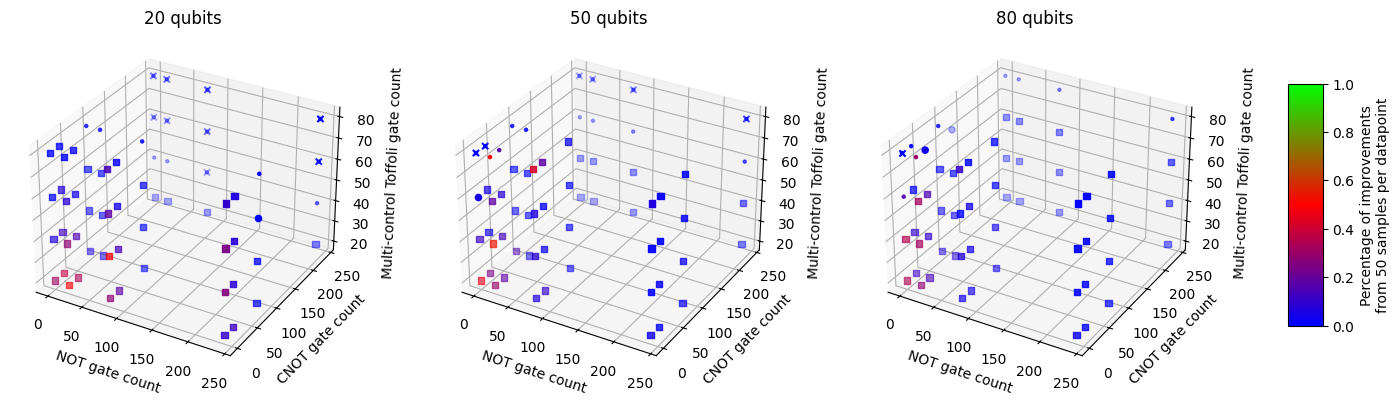

In [7]:
norm = Normalize(vmin=0, vmax=1)
cmap = 'brg'

fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.1], wspace=0.3)

not_cnt0, cnot_cnt0, tof_cnt_used0, average_improvement_terms0, relevance0 = np.array(list(zip(*data_qbit0_occur)))

no_relevance_indices0 = (relevance0 == 0)
low_relevance_indices0 = (relevance0 < 1/3)
mid_relevance_indices0 = (1/3 <= relevance0) & (relevance0 < 2/3)
high_relevance_indices0 = (relevance0 >= 2/3)

ax1 = fig.add_subplot(gs[0], projection='3d')
scatter1_1 = ax1.scatter(not_cnt0[no_relevance_indices0], cnot_cnt0[no_relevance_indices0], tof_cnt_used0[no_relevance_indices0],
                         c=average_improvement_terms0[no_relevance_indices0], norm=norm, cmap=cmap, marker='x')
scatter1_2 = ax1.scatter(not_cnt0[low_relevance_indices0], cnot_cnt0[low_relevance_indices0], tof_cnt_used0[low_relevance_indices0],
                         c=average_improvement_terms0[low_relevance_indices0], norm=norm, cmap=cmap, marker='.')
scatter1_3 = ax1.scatter(not_cnt0[mid_relevance_indices0], cnot_cnt0[mid_relevance_indices0], tof_cnt_used0[mid_relevance_indices0],
                         c=average_improvement_terms0[mid_relevance_indices0], norm=norm, cmap=cmap, marker='o')
scatter1_4 = ax1.scatter(not_cnt0[high_relevance_indices0], cnot_cnt0[high_relevance_indices0], tof_cnt_used0[high_relevance_indices0],
                         c=average_improvement_terms0[high_relevance_indices0], norm=norm, cmap=cmap, marker=',')
ax1.set_title('20 qubits')


not_cnt1, cnot_cnt1, tof_cnt_used1, average_improvement_terms1, relevance1 = np.array(list(zip(*data_qbit1_occur)))

no_relevance_indices1 = (relevance1 == 0)
low_relevance_indices1 = (relevance1 < 1/3)
mid_relevance_indices1 = (1/3 <= relevance1) & (relevance1 < 2/3)
high_relevance_indices1 = (relevance1 >= 2/3)

ax2 = fig.add_subplot(gs[1], projection='3d')
scatter2_1 = ax2.scatter(not_cnt1[no_relevance_indices1], cnot_cnt1[no_relevance_indices1], tof_cnt_used1[no_relevance_indices1],
                         c=average_improvement_terms1[no_relevance_indices1], norm=norm, cmap=cmap, marker='x')
scatter2_2 = ax2.scatter(not_cnt1[low_relevance_indices1], cnot_cnt1[low_relevance_indices1], tof_cnt_used1[low_relevance_indices1],
                         c=average_improvement_terms1[low_relevance_indices1], norm=norm, cmap=cmap, marker='.')
scatter2_3 = ax2.scatter(not_cnt1[mid_relevance_indices1], cnot_cnt1[mid_relevance_indices1], tof_cnt_used1[mid_relevance_indices1],
                         c=average_improvement_terms1[mid_relevance_indices1], norm=norm, cmap=cmap, marker='o')
scatter2_4 = ax2.scatter(not_cnt1[high_relevance_indices1], cnot_cnt1[high_relevance_indices1], tof_cnt_used1[high_relevance_indices1],
                         c=average_improvement_terms1[high_relevance_indices1], norm=norm, cmap=cmap, marker=',')
ax2.set_title('50 qubits')


not_cnt2, cnot_cnt2, tof_cnt_used2, average_improvement_terms2, relevance2 = np.array(list(zip(*data_qbit2_occur)))

no_relevance_indices2 = (relevance2 == 0)
low_relevance_indices2 = (relevance2 < 1/3)
mid_relevance_indices2 = (1/3 <= relevance2) & (relevance2 < 2/3)
high_relevance_indices2 = (relevance2 >= 2/3)

ax3 = fig.add_subplot(gs[2], projection='3d')
scatter3_1 = ax3.scatter(not_cnt2[no_relevance_indices2], cnot_cnt2[no_relevance_indices2], tof_cnt_used2[no_relevance_indices2],
                         c=average_improvement_terms2[no_relevance_indices2], norm=norm, cmap=cmap, marker='x')
scatter3_2 = ax3.scatter(not_cnt2[low_relevance_indices2], cnot_cnt2[low_relevance_indices2], tof_cnt_used2[low_relevance_indices2],
                         c=average_improvement_terms2[low_relevance_indices2], norm=norm, cmap=cmap, marker='.')
scatter3_3 = ax3.scatter(not_cnt2[mid_relevance_indices2], cnot_cnt2[mid_relevance_indices2], tof_cnt_used2[mid_relevance_indices2],
                         c=average_improvement_terms2[mid_relevance_indices2], norm=norm, cmap=cmap, marker='o')
scatter3_4 = ax3.scatter(not_cnt2[high_relevance_indices2], cnot_cnt2[high_relevance_indices2], tof_cnt_used2[high_relevance_indices2],
                         c=average_improvement_terms2[high_relevance_indices2], norm=norm, cmap=cmap, marker=',')
ax3.set_title('80 qubits')


for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('NOT gate count')
    ax.set_ylabel('CNOT gate count')
    ax.set_zlabel('Multi-control Toffoli gate count')

# Add colorbar to the right of all subplots
cax = fig.add_subplot(gs[3])  # Allocate the last column for colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, cax=cax, label='Percentage of improvements\nfrom 50 samples per datapoint', orientation='vertical')

cb.ax.set_aspect(7)

plt.subplots_adjust(right=1.0)
plt.tight_layout()
plt.show()